# Load CHARTS data into Scanpy

#### This notebook implements a function for loading individual tumor datasets into Scanpy's AnnData object.

### Import dependencies

In [9]:
import pandas as pd
from anndata import AnnData
import scanpy as sc
from os.path import join
import numpy as np

### Function for loading data CHARTS data into an AnnData object

In [26]:
def load_tumor(loc, res=1.0):
    """
    Load CHARTS results into an AnnData object.
    
    Parameters
    ----------
    loc: path to directory storing CHARTS output for a single tumor 
        as downloaded from charts.morgridge.org/downloads. This file
        stores five files: expression_log1_tpm.tsv, per_cell.tsv,
        per_cluster.res_0.5.tsv, per_cluster.res_1.tsv, and 
        per_cluster.res_2.tsv.
    res: the clustering resolution to load into the AnnData object
    
    Returns
    ----------
    An AnnData object storing the expression data, in units 
    of log(TPM+1), as well as all analysis results from CHARTS.
    """
    # Load expression data
    expr_df = pd.read_csv(
        join(root, 'expression_log1_tpm.tsv'), 
        sep='\t', 
        index_col=0
    )
    
    # Load per-cell variables
    cell_df = pd.read_csv(
        join(root, 'per_cell.tsv'), 
        sep='\t', 
        index_col=0
    )
    
    # Resolution-specific variables
    if res == 0.5:
        clust_col = 'Cluster (Resolution = 0.5)'
        clust_f = 'per_cluster.res_0.5.tsv'
    elif res == 1.0:
        clust_col = 'Cluster (Resolution = 1.0)'
        clust_f = 'per_cluster.res_1.tsv'
    elif res == 2.0:
        clust_col = 'Cluster (Resolution = 2.0)'
        clust_f = 'per_cluster.res_2.tsv'
        
    # Build AnnData's obs dataframe
    obs_df = pd.DataFrame(
        data={
            'cluster': [str(x) for x in cell_df[clust_col]],
            'malignancy_score': cell_df['Malignancy Score (Entropy)']
        },
        columns=[
            'cluster',
            'malignancy_score'
        ]
    )
    
    # Load per-cluster variables
    clust_df = pd.read_csv(
        join(loc, clust_f),
        sep='\t',
        index_col=0
    )
    cell_clust_mat = np.array([
        clust_df.loc[clust]
        for clust in cell_df[clust_col]
    ])
    cell_clust_df = pd.DataFrame(
        data=[
            clust_df.loc[clust]
            for clust in cell_df[clust_col]
        ],
        index=cell_df.index,
        columns=clust_df.columns
    )
    obs_df = obs_df.join(cell_clust_df)
    
    
    # Create gene-wise dataframe
    var_df = pd.DataFrame(
        index=expr_df.columns,
        data=expr_df.columns
    )
    
    # Build AnnData object
    ad = AnnData(
        X=np.array(expr_df),
        obs=obs_df,
        obsm={
            'X_umap': np.array(cell_df[[
                'UMAP1 (2D)', 
                'UMAP2 (2D)'
            ]])
        },
        var=var_df
    )
    return ad

### Example function call to load dataset

In [ ]:
root = './GSE102130.BCH836'
ad = load_tumor(root, res=1)

### Plot UMAP, color by cluster

... storing 'cluster' as categorical
... storing 'Predicted Cell Type' as categorical


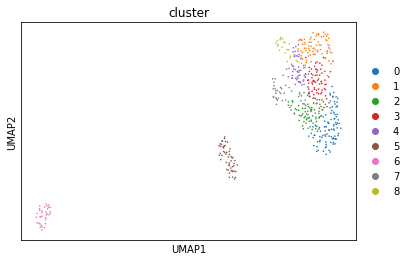

In [27]:
sc.pl.umap(ad, color='cluster', s=10)

### Plot UMAP, color by cell type probability

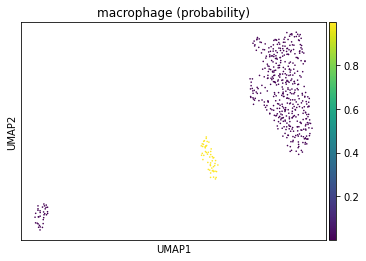

In [29]:
sc.pl.umap(ad, color='macrophage (probability)', s=10)

### Plot UMAP, color by gene set enrichment scores

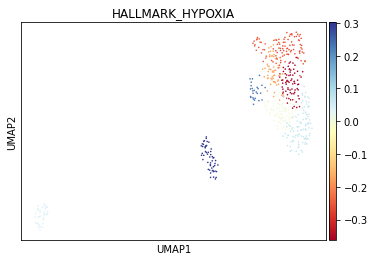

In [31]:
sc.pl.umap(ad, color='HALLMARK_HYPOXIA', cmap='RdYlBu', s=10)